In [18]:
# main01.py is a part of the PYTHIA event generator.
# Copyright (C) 2023 Torbjorn Sjostrand.
# PYTHIA is licenced under the GNU GPL v2 or later, see COPYING for details.
# Please respect the MCnet Guidelines, see GUIDELINES for details.

# Keywords: basic usage; charged multiplicity; python;

# This is a simple test program. It fits on one slide in a talk.  It
# studies the charged multiplicity distribution at the LHC.

# To set the path to the Pythia 8 Python interface do either
# (in a shell prompt):
#      export PYTHONPATH=$(PREFIX_LIB):$PYTHONPATH
# or the following which sets the path from within Python.
import sys
cfg = open("../pythia8309/Makefile.inc")
lib = "../pythia8309/lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)

# Import the Pythia module.
import pythia8
'''
pythia = pythia8.Pythia()
pythia.readString("Beams:eCM = 8000.")
pythia.readString("HardQCD:all = on")
pythia.readString("SoftQCD:all = on")
pythia.readString("PhaseSpace:pTHatMin = 20.")
pythia.init()
'''

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split


In [19]:
import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

In [20]:
maxEvents = 10000
maxLength = 400

In [21]:
def generateData(pythia):

    mult = pythia8.Hist("charged multiplicity", 50, -0.5, 399.5)
    pT = pythia8.Hist("transverse momentum", 50, 0.0, 5.)
    
    data = np.zeros((1,maxLength,3))

    # Begin event loop. Generate event. Skip if error. List first one.
    nChargedMax = 0
    print("start")
    for iEvent in range(0, maxEvents):
        if iEvent%1000 == 0: print(iEvent)
        if not pythia.next(): continue
        # Find number of all final charged particles and fill histogram.
        event = np.zeros((maxLength,3))
    
        nCharged = 0
        for prt in pythia.event:
            if prt.isFinal() and prt.isCharged(): 
                if nCharged < maxLength:
                    event[nCharged,0] = prt.pT()
                    event[nCharged,1] = prt.theta()
                    event[nCharged,2] = prt.phi()
                    pT.fill(prt.pT())
                nCharged += 1
                #print(nCharged)
        if iEvent%1000 == 0: print("nCharged ",nCharged) 
        # sort event by pT
        #print(event)
        event = event[event[:, 0].argsort()[::-1]]
        #print(event)
        # from all Phi angles subtract the phi of the particle with the highest pT
        phi0 = event[0,2]
        for i in range(len(event)):
            event[i,2] = (event[i,2]-phi0)%(2.*np.pi)
            if event[i,2] > np.pi:
                event[i,2] = event[i,2] - 2*np.pi

        event = event.reshape((1,maxLength,3))        
        if iEvent > -1:   
            #print(event)
            data = np.concatenate((data, event), axis=0)
        else:
            #print(event)
            data = event    
        mult.fill(nCharged)
        if nCharged > nChargedMax:
            nChargedMax = nCharged
    
    # End of event loop. Statistics. Histogram. Done.
    print(data.shape)
    #pythia.stat();
    #print(mult)

    print("Max. nCharged = ", nChargedMax)

    return data, mult, pT

In [22]:
# generate data
#pythia = pythia8.Pythia()
#pythia.readString("Beams:eCM =  13.6 TeV")
#pythia.readString("HardQCD:all = on")
#pythia.readString("SoftQCD:all = on")
#pythia.readString("PhaseSpace:pTHatMin = 20.")

#pythia.readString("MultipartonInteractions:pT0Ref = 1")
#pythia.init()

In [23]:
def initPythia(pT0Ref, ecmPow, coreRadius, coreFraction):
    # generate data
    pythia = pythia8.Pythia()
    pythia.readString("Beams:eCM =  13600.")
    #pythia.readString("HardQCD:all = on")
    pythia.readString("SoftQCD:all = on")
    #pythia.readString("PhaseSpace:pTHatMin = 20.")

    auxstr = "MultipartonInteractions:pT0Ref = "+str(pT0Ref)
    pythia.readString(auxstr)
    auxstr = "MultipartonInteractions:ecmPow = "+str(ecmPow)
    pythia.readString(auxstr)  
    auxstr = "MultipartonInteractions:coreRadius = "+str(coreRadius)
    pythia.readString(auxstr)
    auxstr = "MultipartonInteractions:coreFraction = "+str(coreFraction)
    pythia.readString(auxstr) 

    pythia.init()

    return pythia




In [24]:

pythia = initPythia(1.5, 0.07, 0.7, 0.7)
data0, mult0, pT0 = generateData(pythia)

print("Data shape: ",data0.shape)

del pythia

start
0
nCharged  110
1000
nCharged  40
2000
nCharged  44
3000
nCharged  60
4000
nCharged  2
5000
nCharged  60
6000
nCharged  38
7000
nCharged  2
8000
nCharged  62
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  774
Data shape:  (10001, 400, 3)


(array([2644.,  306.,  317.,  404.,  560.,  683.,  519.,  332.,  272.,
         247.,  212.,  174.,  198.,  147.,  129.,  133.,  118.,  107.,
          99.,   97.,   91.,   91.,   88.,   91.,   70.,   94.,   67.,
          62.,   54.,   63.,   58.,   50.,   72.,   72.,   66.,   61.,
          49.,   45.,   52.,   53.,   38.,   41.,   41.,   52.,   46.,
          49.,   42.,   35.,   41.,   53.]),
 array([ -0.5,   7.5,  15.5,  23.5,  31.5,  39.5,  47.5,  55.5,  63.5,
         71.5,  79.5,  87.5,  95.5, 103.5, 111.5, 119.5, 127.5, 135.5,
        143.5, 151.5, 159.5, 167.5, 175.5, 183.5, 191.5, 199.5, 207.5,
        215.5, 223.5, 231.5, 239.5, 247.5, 255.5, 263.5, 271.5, 279.5,
        287.5, 295.5, 303.5, 311.5, 319.5, 327.5, 335.5, 343.5, 351.5,
        359.5, 367.5, 375.5, 383.5, 391.5, 399.5]),
 [<matplotlib.patches.Polygon at 0x7f1433021270>])

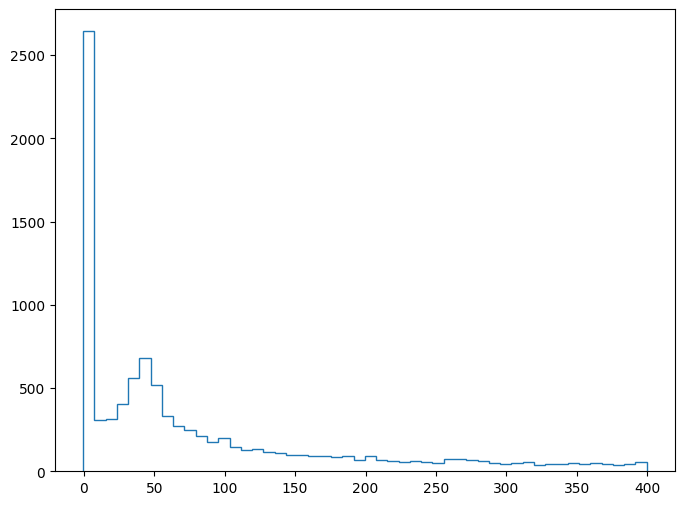

In [25]:
import matplotlib.pyplot as plt

plt.hist(mult0.getBinEdges()[:-1], mult0.getBinEdges(), 
               weights = mult0.getBinContents(), 
               histtype = "step", label = mult0.getTitle()) 

#print(mult)

(array([7.09920e+04, 1.46182e+05, 1.54201e+05, 1.34345e+05, 1.08122e+05,
        8.31920e+04, 6.28230e+04, 4.76560e+04, 3.54240e+04, 2.68790e+04,
        2.08490e+04, 1.67770e+04, 1.35830e+04, 1.12820e+04, 9.17900e+03,
        7.77600e+03, 6.31800e+03, 5.42200e+03, 4.49400e+03, 3.74200e+03,
        3.26900e+03, 2.75100e+03, 2.28700e+03, 2.00800e+03, 1.75000e+03,
        1.47200e+03, 1.23200e+03, 1.03800e+03, 9.18000e+02, 7.73000e+02,
        6.80000e+02, 6.11000e+02, 5.28000e+02, 4.26000e+02, 3.38000e+02,
        3.39000e+02, 3.18000e+02, 2.77000e+02, 2.36000e+02, 1.89000e+02,
        1.71000e+02, 1.39000e+02, 1.23000e+02, 1.22000e+02, 1.00000e+02,
        7.80000e+01, 7.50000e+01, 6.80000e+01, 5.00000e+01, 5.50000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4

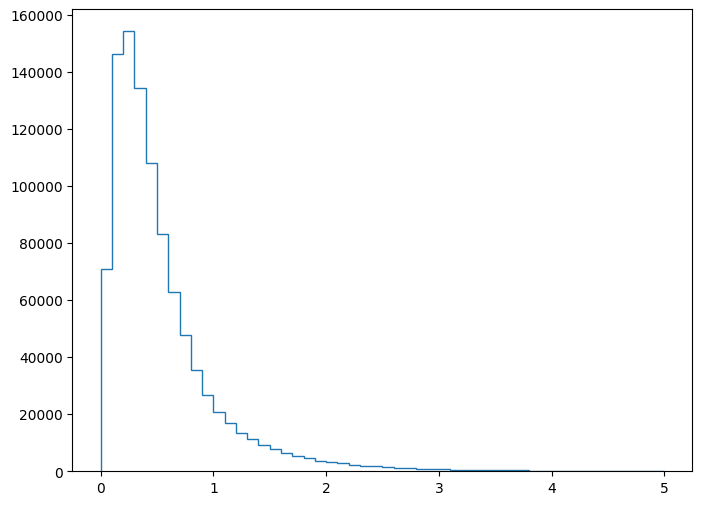

In [26]:
plt.hist(pT0.getBinEdges()[:-1], pT0.getBinEdges(), 
               weights = pT0.getBinContents(), 
               histtype = "step", label = pT0.getTitle()) 

# Implement neural network

In [27]:
def prepareData(data0,data):
    X = np.concatenate((data0,data), axis=0)
    X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

    y = np.zeros((X.shape[0],2))
    y[:data0.shape[0],0] = 1
    y[data0.shape[0]:,1] = 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, shuffle=True, random_state=42)
    return X_train, X_test, y_train, y_test

In [28]:
def createModel(shape):
    # Here is the fully connected (dense) network
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model

In [29]:
def trainModel(model, X_train, X_test, y_train, y_test):
    batch_size = 128
    epochs = 20

    history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))
    return history

In [30]:
def plotAccuracy(history):
    # Plots for training and testing process: loss and accuracy


    n_epochs = len(history.history['loss'])

    plt.figure(0)
    plt.plot(history.history['accuracy'],'r')
    plt.plot(history.history['val_accuracy'],'g')
    plt.xticks(np.arange(0, n_epochs, 10.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])
    plt.show()

In [31]:
def plotLoss(history):
    plt.figure(1)
    plt.plot(history.history['loss'],'r')
    plt.plot(history.history['val_loss'],'g')
    plt.xticks(np.arange(0, n_epochs, 10.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    plt.show()

In [32]:
def optimize(data0,pT0Ref,ecmPow,coreRadius,coreFraction):
    
    pythia = initPythia(pT0Ref,ecmPow,coreRadius,coreFraction)
    print("Pythia initialized")
    data, mult, pT = generateData(pythia)

    print("Data shape: ",data.shape)

    del pythia
    
    ###
    
    X_train, X_test, y_train, y_test = prepareData(data0,data)
    model = createModel(shape=X_train.shape[1])
    history = trainModel(model, X_train, X_test, y_train, y_test)
    plotAccuracy(history)
    accuracy = np.max(history.history['val_accuracy'])

    return accuracy

[I 2023-07-06 23:39:17,962] A new study created in memory with name: no-name-2e00a7a6-1263-4bdd-bac9-dfb60f876a0e


Optuna suggested x =  1.590262927075139 0.32225261933108224 0.6721214194454751 0.4663773310906496
Pythia initialized
start
0
nCharged  2
1000
nCharged  32
2000
nCharged  24
3000
nCharged  2
4000
nCharged  190
5000
nCharged  2
6000
nCharged  314
7000
nCharged  32
8000
nCharged  402
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  588
Data shape:  (10001, 400, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                76864     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                   

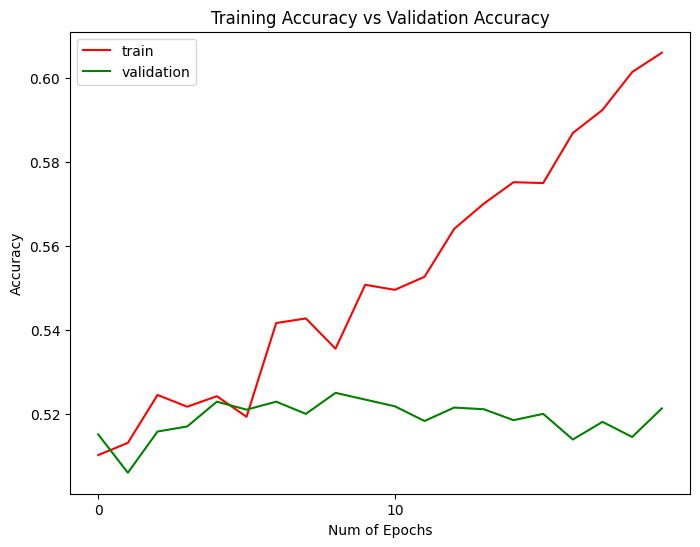

[I 2023-07-06 23:42:21,046] Trial 0 finished with value: 0.5250474810600281 and parameters: {'pT0Ref': 1.590262927075139, 'ecmPow': 0.32225261933108224, 'coreRadius': 0.6721214194454751, 'coreFraction': 0.4663773310906496}. Best is trial 0 with value: 0.5250474810600281.


Optuna suggested x =  2.9968400448087706 0.19628428975724993 0.571428878865525 0.11355941324013302
Pythia initialized
start
0
nCharged  40
1000
nCharged  2
2000
nCharged  114
3000
nCharged  54
4000
nCharged  2
5000
nCharged  4
6000
nCharged  2
7000
nCharged  204
8000
nCharged  122
9000
nCharged  4
(10001, 400, 3)
Max. nCharged =  328
Data shape:  (10001, 400, 3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                76864     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                   

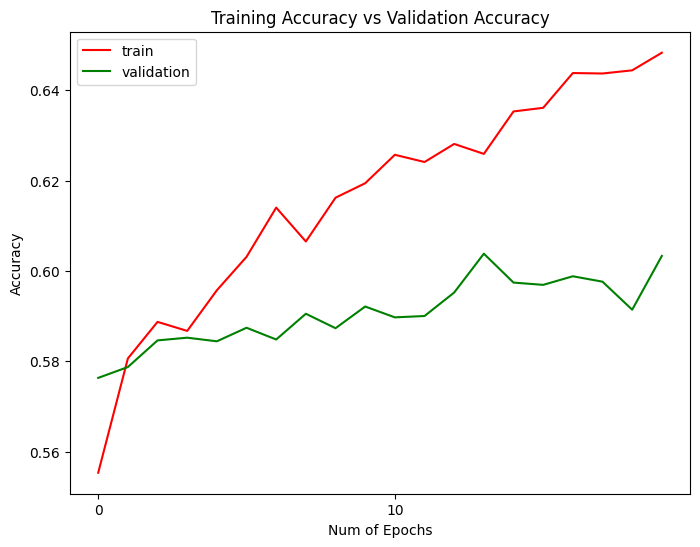

[I 2023-07-06 23:45:22,459] Trial 1 finished with value: 0.603839635848999 and parameters: {'pT0Ref': 2.9968400448087706, 'ecmPow': 0.19628428975724993, 'coreRadius': 0.571428878865525, 'coreFraction': 0.11355941324013302}. Best is trial 0 with value: 0.5250474810600281.


Optuna suggested x =  2.2289229628303735 0.37664163844765064 0.8468265833194817 0.1201524400008323
Pythia initialized
start
0
nCharged  28
1000
nCharged  126
2000
nCharged  154
3000
nCharged  236
4000
nCharged  28
5000
nCharged  6
6000
nCharged  46
7000
nCharged  58
8000
nCharged  54
9000
nCharged  44
(10001, 400, 3)
Max. nCharged =  402
Data shape:  (10001, 400, 3)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                76864     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
               

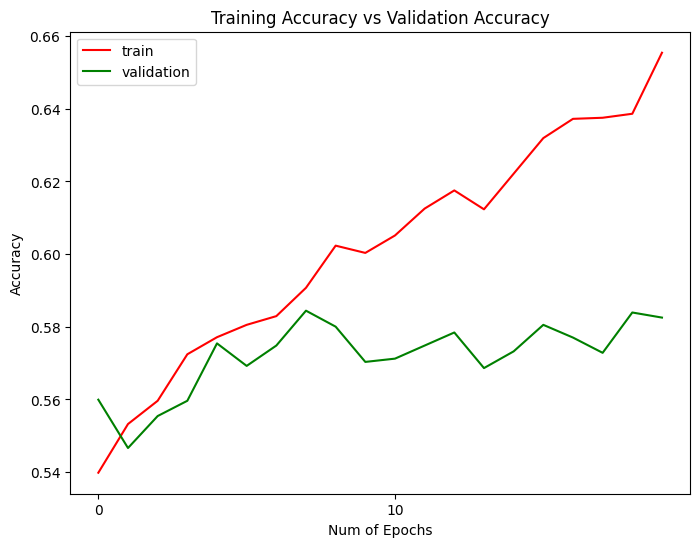

[I 2023-07-06 23:48:06,455] Trial 2 finished with value: 0.5844415426254272 and parameters: {'pT0Ref': 2.2289229628303735, 'ecmPow': 0.37664163844765064, 'coreRadius': 0.8468265833194817, 'coreFraction': 0.1201524400008323}. Best is trial 0 with value: 0.5250474810600281.


Optuna suggested x =  2.1863694853509417 0.3283383379493956 0.6492471204364999 0.2583288435349689
Pythia initialized
start
0
nCharged  66
1000
nCharged  188
2000
nCharged  2
3000
nCharged  86
4000
nCharged  116
5000
nCharged  124
6000
nCharged  42
7000
nCharged  124
8000
nCharged  2
9000
nCharged  68
(10001, 400, 3)
Max. nCharged =  424
Data shape:  (10001, 400, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                76864     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                

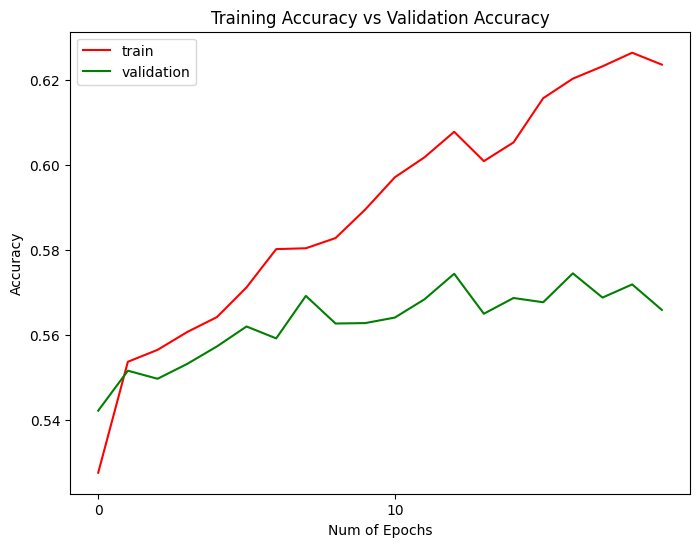

[I 2023-07-06 23:51:25,616] Trial 3 finished with value: 0.5745425224304199 and parameters: {'pT0Ref': 2.1863694853509417, 'ecmPow': 0.3283383379493956, 'coreRadius': 0.6492471204364999, 'coreFraction': 0.2583288435349689}. Best is trial 0 with value: 0.5250474810600281.


Optuna suggested x =  2.1933618732825577 0.2205851009017985 0.3520841956621189 0.7495378775964981
Pythia initialized
start
0
nCharged  18
1000
nCharged  2
2000
nCharged  34
3000
nCharged  2
4000
nCharged  18
5000
nCharged  24
6000
nCharged  2
7000
nCharged  144
8000
nCharged  48
9000
nCharged  62
(10001, 400, 3)
Max. nCharged =  496
Data shape:  (10001, 400, 3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                76864     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                    

In [ ]:
n_trials=100

def objective(trial):
    pT0Ref = trial.suggest_float('pT0Ref', 0.5, 4)
    ecmPow = trial.suggest_float('ecmPow', 0.1, 0.4)
    coreRadius = trial.suggest_float('coreRadius', 0.1, 1.0)
    coreFraction = trial.suggest_float('coreFraction', 0.1, 1.0)
    print("Optuna suggested x = ",pT0Ref, ecmPow, coreRadius, coreFraction)
    accuracy = optimize(data0, pT0Ref, ecmPow, coreRadius, coreFraction)
    return accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

study.best_params 

In [ ]:
study.best_trials

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_intermediate_values(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_param_importances(study)